In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/test.csv')

In [5]:
train['comment'] = train['comment'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')
test['comment'] = test['comment'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')

In [6]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '자', '에', '와', '한', '하다']

In [7]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 161kB/s 
     |████████████████████████████████| 460kB 56.6MB/s 
     |████████████████████████████████| 92kB 12.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [8]:
train_list_X = train.comment.to_list()
train_list_y = train.label.to_list()
test_list_X = test.comment.to_list()
test_list_y = test.label.to_list()

In [9]:
len(train_list_X), len(train_list_y), len(test_list_X), len(test_list_y)

(28236, 28236, 4515, 4515)

In [10]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

- train data

In [11]:
maxlen = 2000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(train_list_X)
sequences = tokenizer.texts_to_sequences(train_list_X)

word_index = tokenizer.word_index
print('{}개의 고유한 토큰을 찾았습니다.'.format(len(word_index)))

92581개의 고유한 토큰을 찾았습니다.


In [12]:
data_train = pad_sequences(sequences, maxlen = maxlen)
labels_train = np.array(train_list_y)

data_train.shape, labels_train.shape

((28236, 2000), (28236,))

- test data

In [13]:
maxlen = 2000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(test_list_X)
sequences = tokenizer.texts_to_sequences(test_list_X)

word_index = tokenizer.word_index
print('{}개의 고유한 토큰을 찾았습니다.'.format(len(word_index)))

28775개의 고유한 토큰을 찾았습니다.


In [14]:
data_test = pad_sequences(sequences, maxlen = maxlen)
labels_test = np.array(test_list_y)

data_test.shape, labels_test.shape

((4515, 2000), (4515,))

- train valid split

In [15]:
indices = np.arange(data_train.shape[0])
np.random.shuffle(indices)
data = data_train[indices]
labels = labels_train[indices]

In [17]:
training_samples = 20000

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples:]
y_valid = labels[training_samples:]

In [16]:
import tensorflow_hub as hub

embeddings_index = hub.load('https://tfhub.dev/google/tf2-preview/nnlm-ko-dim128-with-normalization/1')

In [18]:
embeddings_index([''])
# ?? 판새가 있다고?

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-1.82610840e-01, -2.71886867e-03,  6.46980628e-02,
         7.22297803e-02, -2.81831026e-02, -7.85918310e-02,
        -1.07683223e-02, -6.43315399e-03, -1.24962814e-01,
        -1.52119458e-01,  9.63070337e-03,  8.88594463e-02,
         1.93727657e-01,  1.45815477e-01,  6.35704547e-02,
         3.17381620e-02,  1.65435404e-03,  1.60897940e-01,
         2.10208118e-01, -1.57924704e-02, -7.39542320e-02,
         5.22503480e-02,  4.00299579e-02,  3.14177051e-02,
         2.80258786e-02, -1.49299443e-01, -6.92114830e-02,
        -2.37217546e-02,  1.56167224e-01,  2.65407655e-02,
        -4.18795943e-02, -4.93632406e-02, -1.05662353e-01,
        -8.28058198e-02,  1.40575036e-01,  1.15573458e-01,
         8.68666023e-02,  1.96279289e-04, -8.16652104e-02,
        -7.42786974e-02, -1.35161325e-01,  1.12149585e-02,
        -6.37857616e-02, -2.68632248e-02, -1.37057021e-01,
         6.78175017e-02,  1.00739345e-01, -1.09537870e-01,
      

In [21]:
embedding_dim = 128

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index([word])
  if i < max_words:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(10000, 128)

In [30]:
from keras import models
from keras import layers

comment_model = models.Sequential()

comment_model.add(layers.Embedding(max_words,
                                   embedding_dim,
                                   input_length = maxlen))

comment_model.add(layers.LSTM(32))
comment_model.add(layers.Dropout(0.5))
comment_model.add(layers.Dense(1, activation = 'sigmoid'))

comment_model.layers[0].set_weights([embedding_matrix])
comment_model.layers[0].trainable = False

In [31]:
comment_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 128)         1280000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,300,641
Trainable params: 20,641
Non-trainable params: 1,280,000
_________________________________________________________________


In [32]:
comment_model.compile(loss = 'binary_crossentropy',
                      optimizer = 'adam',
                      metrics = ['accuracy'])

In [33]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1)

In [39]:
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/project/best_comment_model.h5',
                     monitor = 'val_accuracy',
                     mode = 'max',
                     save_best_only = True,
                     verbose = 1)

In [40]:
%%time

Hist = comment_model.fit(X_train, y_train,
                         epochs = 500,
                         batch_size = 512,
                         validation_data = (X_valid, y_valid),
                         callbacks = [es, mc],
                         verbose = 1)

Epoch 1/500
40/40 [==============================] - 20s 503ms/step - loss: 0.6902 - accuracy: 0.5358 - val_loss: 0.6866 - val_accuracy: 0.5493

Epoch 00001: val_accuracy improved from -inf to 0.54930, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model.h5
Epoch 2/500
40/40 [==============================] - 19s 488ms/step - loss: 0.6861 - accuracy: 0.5504 - val_loss: 0.6847 - val_accuracy: 0.5658

Epoch 00002: val_accuracy improved from 0.54930 to 0.56581, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model.h5
Epoch 3/500
40/40 [==============================] - 19s 486ms/step - loss: 0.6842 - accuracy: 0.5572 - val_loss: 0.6828 - val_accuracy: 0.5668

Epoch 00003: val_accuracy improved from 0.56581 to 0.56678, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model.h5
Epoch 4/500
40/40 [==============================] - 20s 494ms/step - loss: 0.6818 - accuracy: 0.5652 - val_loss: 0.6812 - val_accura

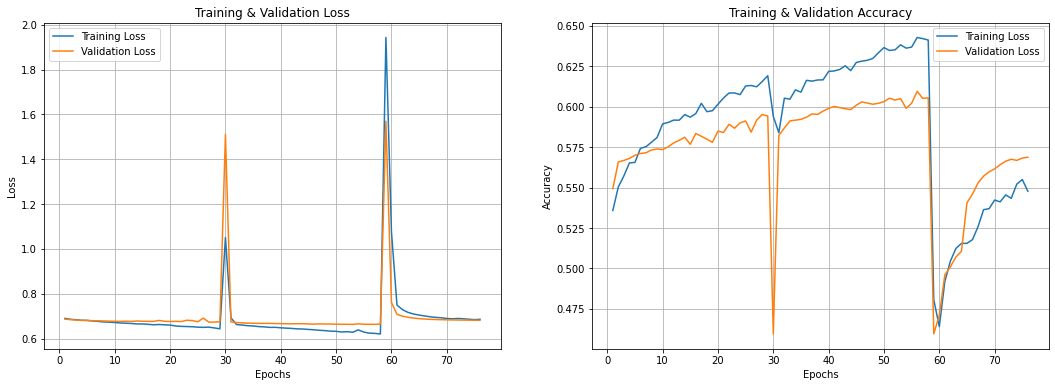

In [42]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (18, 6))

for num, value in enumerate(['loss', 'accuracy']):
  plt.subplot(1, 2, num + 1)
  plt.plot(epochs, Hist.history['{}'.format(value)])
  plt.plot(epochs, Hist.history['val_{}'.format(value)])
  plt.title('Training & Validation {}'.format(value.title()))
  plt.xlabel('Epochs')
  plt.ylabel('{}'.format(value.title()))
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.grid()
plt.show()

In [44]:
comment_model.evaluate(data_test, labels_test)

142/142 [==============================] - 16s 111ms/step - loss: 0.6684 - accuracy: 0.6277


[0.6684361100196838, 0.6276854872703552]

In [1]:
from keras.models import load_model

In [15]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/project/best_comment_model.h5')

loaded_model.evaluate(data_test, labels_test)

142/142 [==============================] - 36s 33ms/step - loss: 0.7558 - accuracy: 0.5595


[0.7557763457298279, 0.5594684481620789]